In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

import scipy.stats as stats
norm = stats.norm

In [2]:
from bandit import ThompsonSamplingAgent

In [3]:
def get_arm_attr(bandit, arm):
    mu = bandit.mu[arm]
    sigma = 1/np.sqrt(bandit.tau[arm])
    counter = bandit.action_counter[arm] 
    return mu, sigma, counter

In [4]:
def plot_posteriors(bandit, ax=None):
    if not ax:
        ax = plt.gca();
    ax.set_title(f"{bandit.steps} Trials") 
    ymax = 0

    for arm in range(bandit.k):
        # get the PDF of the socket using its estimates
        mu, sigma, counter = get_arm_attr(bandit, arm)

        x_min = max(-8,norm.ppf(0.005,mu,sigma))
        x_max = min(8, norm.ppf(0.995,mu,sigma))

        x = np.linspace(x_min, x_max, 100)
        y = norm.pdf(x, mu, sigma)
    
        p = ax.plot(x, y, lw=2, label = f'{counter}/{bandit.steps}')
        c = p[0].get_markeredgecolor()    
        ax.fill_between(x, y, 0, color=c, alpha=0.2 )    
        ax.vlines(mu, 0, y.max(), color = c, ls = "--", lw = 2)   
        
        ax.legend()
        ymax = max(ymax, y.max()*1.05) 

    ax.set_ylim([0,ymax]);    

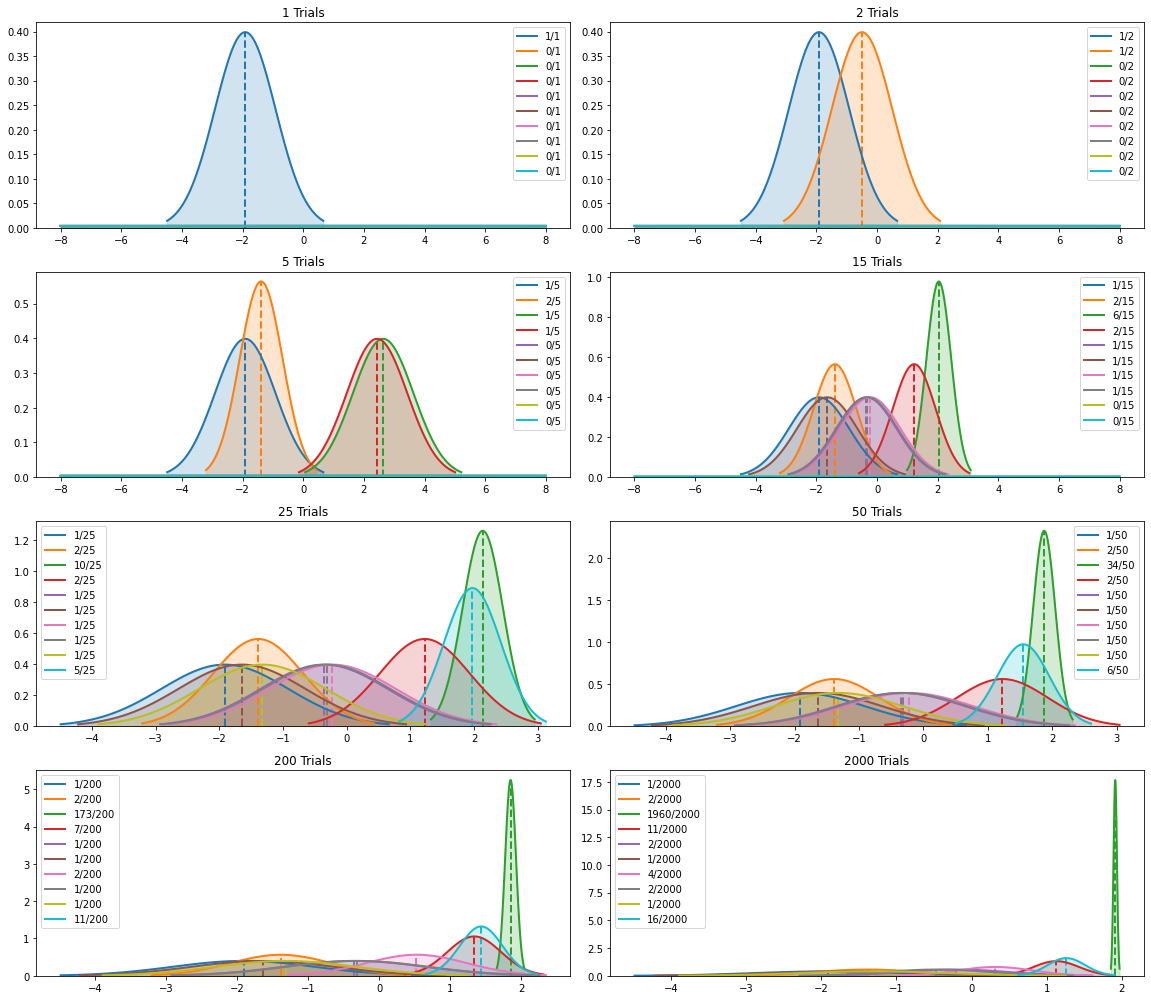

In [5]:
draw_samples = [1, 2, 5, 15, 25, 50, 200, 2000]
k = 10
bandit = ThompsonSamplingAgent(k=k)

fig, axs = plt.subplots(nrows=4, ncols=2, sharex=False, figsize=(16,14));
for i, sample in enumerate(draw_samples):
    train_steps =  sample - bandit.steps
    bandit.train(train_steps)
    row = int(i/2)
    col = i%2
    plot_posteriors(bandit, ax=axs[row, col])
plt.tight_layout()


In [6]:
%matplotlib inline
# stop the initial figure from being shown

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import scipy.stats as stats
norm = stats.norm

x_min = -5
x_max = 5
y_min = 0
y_max = 1

x = np.linspace(x_min, x_max, 200)

# create background figure and axes
fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))
ax.set_xlabel('Reward')
ax.set_ylabel('Density')
ax.set_title('Probability density of rewards')

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# generate bandit
k = 10
bandit = ThompsonSamplingAgent(k=k)
 

# define a text list for the legend - standard legends dont work well with animation
texts = [ax.text(0.88, 0.95 - i*0.05,  '', transform=ax.transAxes) for i in range(k+2)]
texts[1].set_text('Arms:')  

# define the legend lines
axlines = [ax.axhline(y=0.86 - i*0.05, xmin=0.84, xmax=0.87, lw=3, color=colors[i]) for i in range(k)]

# define the true value lines
true_rew_lines = [ax.axvline(x=bandit.action_values[i], lw=2, ls='--', color=colors[i]) for i in range(k)]


# create lists of lines
lines = sum([ax.plot([],[],lw=2) for _ in range(k)],[])
fillbet = plt.fill_between(x, x, label="fill")

def init():
    for line in lines:
        line.set_data([],[])
    for line in axlines:
        line.set_data([],[])
    return lines + axlines

# don't show the plain background
plt.close()

# define function to draw each frame
def drawframe(n):
    global y_max
    
    for collection in ax.collections:
        if (str(collection.get_label()) == "fill"):
            collection.remove()
    
    # update the PDFs
    for arm in range(bandit.k):
        # get the PDF of the socket using its estimates
        mu, sigma, counter = get_arm_attr(bandit, arm)
        y = norm.pdf(x, mu, sigma)
        lines[arm].set_data(x, y)
        c = lines[arm].get_markeredgecolor()
        fillbet = ax.fill_between(x, y, 0, color=c, alpha=0.2, label='fill')    
        y_max = max(y_max, y.max()*1.05)
        ax.set_ylim([0, y_max]) 
    
    # update the legends
    texts[0].set_text(f"{n} Trials")
    texts[1].set_text('Arms:')
    for arm in range(bandit.k):
        _, _, counter = get_arm_attr(bandit, arm)
        texts[arm + 2].set_text(f'{arm}: {counter}')
        c = lines[arm].get_markeredgecolor()
        axlines[arm].remove()
        axlines[arm] = ax.axhline(y=y_max*(0.86 - arm*0.05), xmin=0.84, xmax=0.87, lw=3, color=c)
    
    # train the bandit (1 step only)
    bandit.train(1)
    return lines

In [7]:
# create animiation object and render in HTML video
anim = FuncAnimation(fig, drawframe, init_func=init, frames=200, interval=100, blit=True)
HTML(anim.to_html5_video())